# Le but du TP est de predire le prix dans la compétition

In [ ]:
#import des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
import math
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from time import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Définition d'une fonction qui affiche les différents pourcentages
def pourcentage(data):
    n = data.shape[0]
    #me permet de rechercher les valeurs manquantes
    ret = pd.DataFrame(data.isnull().sum(), columns=['nb_manquants'])
    #permet de chercher le pourcentage des valeurs manquantes
    ret['pourcentage_manquant'] = (ret['nb_manquants']/n)*100
    #permet de déterminer le type des données
    ret['types'] = data.dtypes
    #permet de rechercher les doublons dans le tableau
    ret['doublons'] = data.duplicated(keep=False).sum()
    #permet de rechercher le pourcentage de valeurs manquantes dans le tableau
    ret['NAN'] = data.isna().sum()
    return ret

In [ ]:
#Importation de la base de données
df = pd.read_csv('/kaggle/input/house-price/house.csv')

In [ ]:
df.shape

(1460, 81)

In [ ]:
#regardons les données
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Nous avons obtenus un ensemble d'informations importantes notamment sur le type des différentes varibales et aussi observés qu'un ensemble de variables ne sont pas totalement rempli**
**Nous allons confirmer cette observation via un schéma**

In [ ]:
#Cette fonction me permet de représenter les variables ayant un seuil de remplissage inférieur à 10%
#recherchons les valeurs manquantes par un schéma
def valeurs_manquantes(data, thresh=20, color='black', edgecolor='black', height=5, width=15):
    plt.figure(figsize=(width, height))
    percentage = (data.isnull().mean())*100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color='r', linestyle='-')
    plt.title('Valeurs manquates par colonne', fontsize=20, weight='bold')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh + 12.5, f'Colonnes avec plus de {thresh}% de valeurs manquantes', fontsize=12, color='red', ha = 'left', va = 'top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Colonnes avec moins de {thresh}% de valeurs manquantes', fontsize=12, color='blue', ha = 'left', va = 'top')
    plt.xlabel('Colonnes', size=15, weight='bold')
    plt.ylabel('Pourcentage', size=15, weight='bold')
    plt.yticks(weight='bold')
    return plt.show()

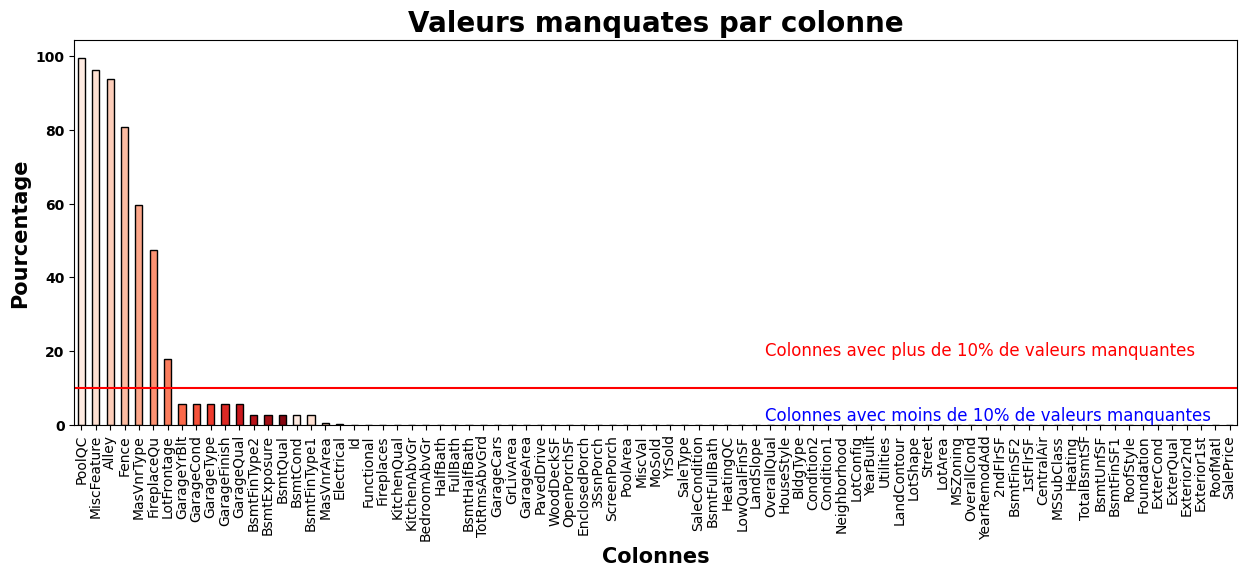

In [ ]:
valeurs_manquantes(df, thresh=10, color=sns.color_palette('Reds', 15))

**Nous constatons qu'il y'a des variables qui nous ne servirons pas car trop peu de données ainsi nous allons enlevé celà de notre bd**

In [ ]:
#supprimons toutes les colonnes n'ayant pas 1460 données complètes
df = df.drop(columns=['PoolQC', 'Fence', 'FireplaceQu', 'Alley', 'MiscFeature', 'LotFrontage'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

**Maintenant que nous avons supprimé les données insuffisantes nous allons maintenant rechercher les valeurs manquantes celon les types de données**

In [ ]:
#séparation des données (prise des varibales numériques)
data_num = df.select_dtypes(include=['float64', 'int64'])
data_num.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [ ]:
#recherchons les valeurs manquantes et null
pourcentage(data_num)

,nb_manquants,pourcentage_manquant,types,doublons,NAN
Id,0,0.000000,int64,0,0
MSSubClass,0,0.000000,int64,0,0
LotArea,0,0.000000,int64,0,0
OverallQual,0,0.000000,int64,0,0
OverallCond,0,0.000000,int64,0,0
YearBuilt,0,0.000000,int64,0,0
YearRemodAdd,0,0.000000,int64,0,0
MasVnrArea,8,0.547945,float64,0,8
BsmtFinSF1,0,0.000000,int64,0,0
BsmtFinSF2,0,0.000000,int64,0,0


**Nous constatons des valeurs manquantes sur certaines variables que nous pouvons remplir par un simple knnimputer**

In [ ]:
data_num = data_num.interpolate()
pourcentage(data_num)

,nb_manquants,pourcentage_manquant,types,doublons,NAN
Id,0,0.0,int64,0,0
MSSubClass,0,0.0,int64,0,0
LotArea,0,0.0,int64,0,0
OverallQual,0,0.0,int64,0,0
OverallCond,0,0.0,int64,0,0
YearBuilt,0,0.0,int64,0,0
YearRemodAdd,0,0.0,int64,0,0
MasVnrArea,0,0.0,float64,0,0
BsmtFinSF1,0,0.0,int64,0,0
BsmtFinSF2,0,0.0,int64,0,0


In [ ]:
data_num.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


**les valeurs numériques sont déjà propres occupons maintenant des valeurs quanlitatives**

In [ ]:
#Recherchons au travers des schémas les variables que l'on peut binariser
data_obj = df.select_dtypes(include=['object'])
data_obj.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [ ]:
data_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   Utilities      1460 non-null   object
 5   LotConfig      1460 non-null   object
 6   LandSlope      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   Condition2     1460 non-null   object
 10  BldgType       1460 non-null   object
 11  HouseStyle     1460 non-null   object
 12  RoofStyle      1460 non-null   object
 13  RoofMatl       1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  MasVnrType     588 non-null    object
 17  ExterQual      1460 non-null   object
 18  ExterCond      1460 non-null

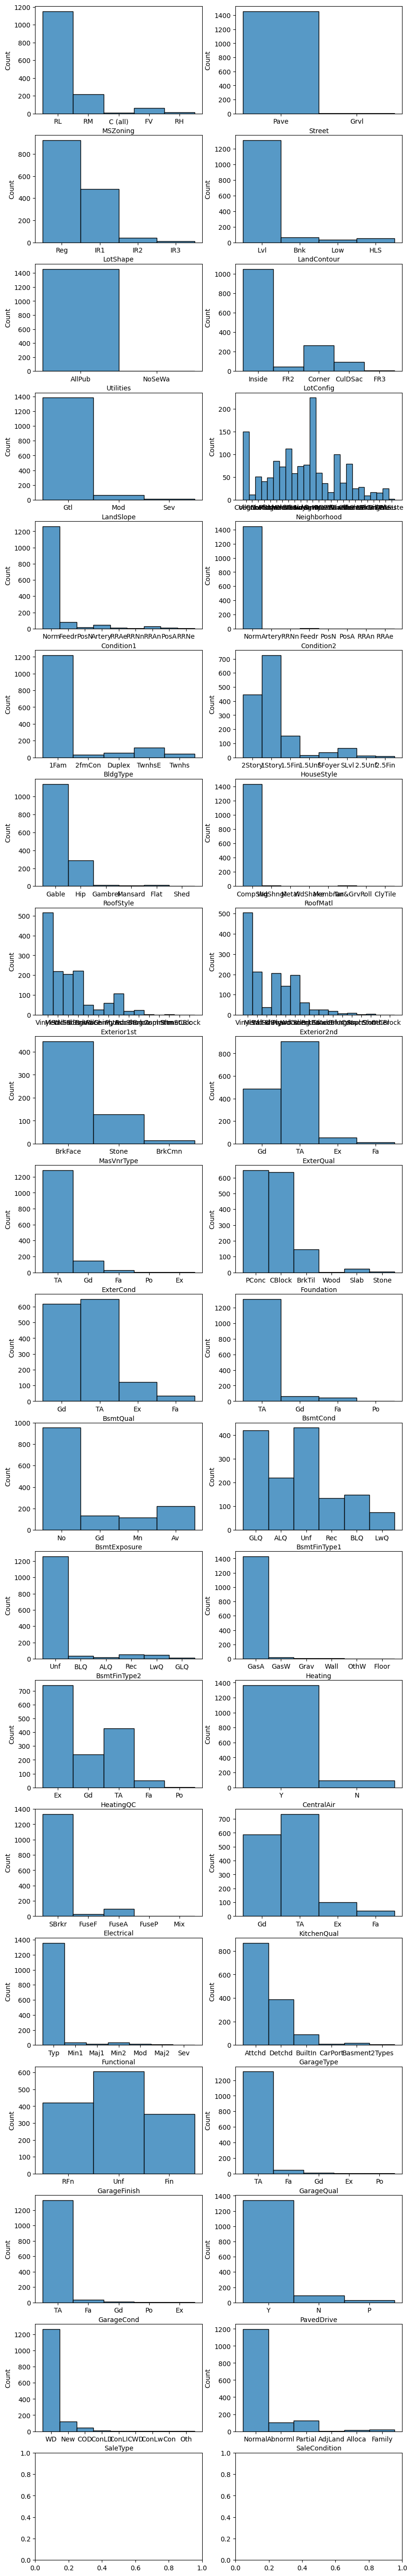

In [ ]:
#recupérons toutes les colonnes de la variable data_obj
colonne_obj = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
              'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
               'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
               'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish','GarageQual',
              'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
#Tracons celà
fig, axs = plt.subplots(20, 2, figsize=(10, 70))
for f, ax in zip(colonne_obj, axs.ravel()):
    sns.histplot(data_obj, x=f, ax=ax)

plt.show()

**Nous constatons sur les figures ci-dessous que nous  n'avons que 3 varibales succeptibles d'être binariser il s'agit de  :**
1. Street (Pave, Grvl)
2. Utilities (AllPub, NoSeWa)
3. CentralAir (Y, N)

In [ ]:
#Numérisation des données Street, Utilities et CentralAir
features = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
              'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
               'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
               'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish','GarageQual',
              'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
data_obj = data_obj.drop(columns=features, axis=1)

In [ ]:
data_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Street      1460 non-null   object
 1   Utilities   1460 non-null   object
 2   CentralAir  1460 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


In [ ]:
#numérisons les données de data_obj
data_obj['Street'].replace(['Pave', 'Grvl'], [1, 0], inplace = True)
data_obj['Utilities'].replace(['AllPub', 'NoSeWa'], [1, 0], inplace = True)
data_obj['CentralAir'].replace(['Y', 'N'], [1, 0], inplace = True)

In [ ]:
data_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Street      1460 non-null   int64
 1   Utilities   1460 non-null   int64
 2   CentralAir  1460 non-null   int64
dtypes: int64(3)
memory usage: 34.3 KB


**Nous allons maintenant fusionner avec la data_num afin d'avoir la base de données finale de notre tp**

In [ ]:
#ajout des données dans data_num
data_num['Street'] = data_obj['Street']
data_num['Utilities'] = data_obj['Utilities']
data_num['CentralAir'] = data_obj['CentralAir']
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [ ]:
data_finale = data_num

**Séparation des données en observation et cible**

In [ ]:
Y = data_finale['SalePrice']
X = data_finale.drop('SalePrice', axis=1)

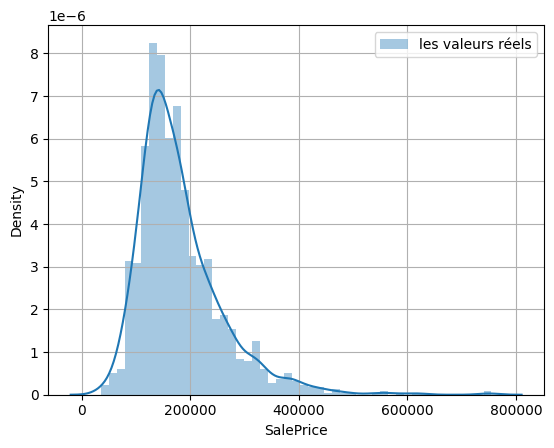

In [ ]:
#représentation de la variable cible
plt.grid(True)
sns.distplot(Y, label='les valeurs réels')
plt.legend()
plt.show()

In [ ]:
t = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = t, random_state = 5)
print(X_train.shape)
print(X_test.shape)

(1168, 39)
(292, 39)


In [ ]:
#Etant un nombre que nous voulons déterminer alors il s'agit d'un régression
#liste des méthodes de regression
regression = [
    GaussianNB(),
    SVC(),
    KNeighborsRegressor(),
    LogisticRegression(),
    LinearRegression(),
    RandomForestRegressor(),
    SVR(),
    DecisionTreeRegressor()
]

In [ ]:
#Définition d'une fonction qui permet d'afficher le temps d'entrainement, le temps de prédiction
# et les différentes metriques
head = 9
#je parcours mon tableau de regression
for model in regression[:head]:
    #je recupere le temps de début
    start = time()
    #j'entraine chaque données
    model.fit(X_train, Y_train)
    #je recupère le temps d'execution
    train_time = time() - start
    start = time()
    #je recupère la prédiction de chaque modèle
    Y_pred = model.predict(X_test)
    #je recupère le temps de prédiction
    predict_time = time()-start
    print(model)
    print("\t Temps d'entrainement : %0.3fs" % train_time)
    print("\t Temps de prédiction : %0.3fs" % predict_time)
    print("\t Le score train : %0.3f" % model.score(X_train, Y_train))
    print("\t Le score test : %0.3f" % model.score(X_test, Y_test))
    print("\t MAE score :", mean_absolute_error(Y_test, Y_pred))
    print("\t MSE score :", mean_squared_error(Y_test, Y_pred))
    print("\t R2 score :", r2_score(Y_test, Y_pred))
    print()

GaussianNB()
	 Temps d'entrainement : 0.051s
	 Temps de prédiction : 0.047s
	 Le score train : 0.682
	 Le score test : 0.007
	 MAE score : 29662.27397260274
	 MSE score : 3142161243.6438355
	 R2 score : 0.5158462174214176

SVC()
	 Temps d'entrainement : 0.743s
	 Temps de prédiction : 0.715s
	 Le score train : 0.023
	 Le score test : 0.007
	 MAE score : 58056.07534246575
	 MSE score : 7652487613.506849
	 R2 score : -0.17911861834263343

KNeighborsRegressor()
	 Temps d'entrainement : 0.003s
	 Temps de prédiction : 0.053s
	 Le score train : 0.775
	 Le score test : 0.557
	 MAE score : 31340.06643835616
	 MSE score : 2876516710.235206
	 R2 score : 0.5567775368854574

LogisticRegression()
	 Temps d'entrainement : 6.012s
	 Temps de prédiction : 0.013s
	 Le score train : 0.070
	 Le score test : 0.017
	 MAE score : 43714.979452054795
	 MSE score : 4770723729.945206
	 R2 score : 0.2649123452328511

LinearRegression()
	 Temps d'entrainement : 0.031s
	 Temps de prédiction : 0.006s
	 Le score train

**Nous constatons que 3 algorithmes se démarquent sur 3 plans qui sont  :**
1. LinearRegression()
2. DecisionTreeRegressor()
3. RandomForestRegressor()

# LinearRegression()

In [ ]:
#Création du modèle de linearRegression()
modelRL = LinearRegression()

In [ ]:
#Entrainement du modèle
modelRL.fit(X_train, Y_train)

LinearRegression()

In [ ]:
#Mise en place des paramètres d'optimisation
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False], 'positive':[True,False]}

In [ ]:
#lancons les différents parametres dans le grid
kf = KFold(n_splits = 5, shuffle=True, random_state = 5)
grid = GridSearchCV(modelRL, parameters, cv=kf, verbose=1)

In [ ]:
#entrainons le grid
modelRL = grid.fit(X_train, Y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
#affichons les différents résultats
print("Meilleur score : ",modelRL.best_score_)#notons ici qu'il était de 0.806
print("Meilleur parametre : ", modelRL.best_params_)

Meilleur score :  0.7302125027318521
Meilleur parametre :  {'copy_X': True, 'fit_intercept': True, 'positive': False}


**Notons que la différence se fait par l'hyperparamètre positive qui a été utilisé par defaut False et a donné un meilleur score. cependant la recherche des meilleurs paramètres recommande à True**

In [ ]:
modelRL = LinearRegression(fit_intercept=True, copy_X=True, positive=True)

In [ ]:
modelRL.fit(X_train, Y_train)

LinearRegression(positive=True)

In [ ]:
#score des entrainements
modelRL.score(X_train, Y_train)

0.7911515655940121

In [ ]:
#score des tests
modelRL.score(X_test, Y_test)

0.8260869172842124

In [ ]:
#mise en place des équations
print("Equation est sous la forme AX + B\n")
print("A = ", modelRL.coef_)
print("\n\n B = \n", modelRL.intercept_)

Equation est sous la forme AX + B

A =  [0.00000000e+00 0.00000000e+00 4.62773105e-01 1.92957696e+04
 4.81567171e+03 2.52319749e+02 1.91729115e+02 2.03521076e+01
 6.99084590e+00 1.25574829e+00 0.00000000e+00 1.08474420e+01
 3.80837393e+01 2.84422054e+01 2.24754319e+01 0.00000000e+00
 9.95839911e+03 0.00000000e+00 1.08853767e+03 9.21099886e+02
 0.00000000e+00 0.00000000e+00 3.33151285e+03 7.11059191e+03
 1.43478895e+02 1.21406580e+04 6.55400126e+00 2.34282537e+01
 0.00000000e+00 2.87013138e+01 2.68372945e+01 7.58740771e+01
 0.00000000e+00 0.00000000e+00 1.49159556e+02 0.00000000e+00
 2.10603952e+04 5.01542010e+04 0.00000000e+00]


 B = 
 -1334630.0753995539


In [ ]:
#mise en place de la prédiction
Y_pred_RL = modelRL.predict(X_test)

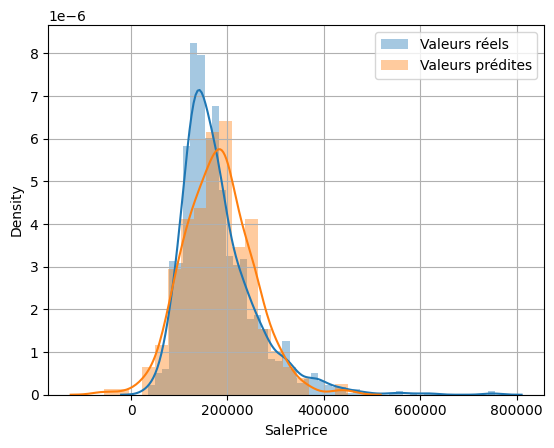

In [ ]:
#représentation des données réels et prédites
plt.grid(True)
sns.distplot(Y, label="Valeurs réels")
sns.distplot(Y_pred_RL, label="Valeurs prédites")
plt.legend()
plt.show()

# DecisionTreeRegressor()

In [ ]:
#Création du modèle de DecisionTreeRegressor()
modelDTR = DecisionTreeRegressor()

In [ ]:
#Entrainement du modèle
modelDTR.fit(X_train, Y_train)

DecisionTreeRegressor()

In [ ]:
#Mise en place des paramètres d'optimisation
parameters = {'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
              'splitter': ["best", "random"], 'max_features': ["auto", "sqrt", "log2"]}

In [ ]:
#lancons la construction de la grille avec plusieurs estimateurs
kf = KFold(n_splits = 5, shuffle=True, random_state=5)
grid = GridSearchCV(modelDTR, parameters, cv=kf, verbose=1)

In [ ]:
#entrainons le grid
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             verbose=1)

In [ ]:
#affichons les meilleurs estimations
grid.best_estimator_

DecisionTreeRegressor(criterion='poisson', max_features='log2')

In [ ]:
#affichons le best score
grid.best_score_

0.6450514941834842

In [ ]:
#affichons le best model
modelDTR = grid.best_estimator_
modelDTR

DecisionTreeRegressor(criterion='poisson', max_features='log2')

In [ ]:
modelDTR.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='poisson', max_features='log2')

In [ ]:
modelDTR.score(X_train, Y_train)

1.0

In [ ]:
modelDTR.score(X_test, Y_test)

0.5724691539425095

In [ ]:
Y_pred_DTR = modelDTR.predict(X_test)

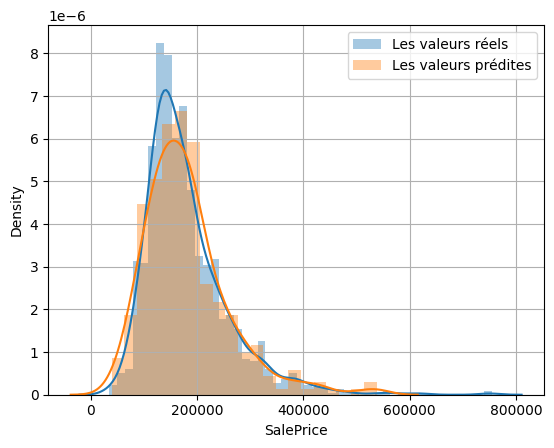

In [ ]:
#tracons le résultat obtenu
plt.grid(True)
sns.distplot(Y, label='Les valeurs réels')
sns.distplot(Y_pred_DTR, label='Les valeurs prédites')
plt.legend()
plt.show()

# RandomForestRegressor()

In [ ]:
#Création du modèle de RandomForestRegressor()
modelRFR= RandomForestRegressor()
modelRFR

RandomForestRegressor()

In [ ]:
#Entrainement du modèle
modelRFR.fit(X_train, Y_train)

RandomForestRegressor()

In [ ]:
#Mise en place des paramètres d'optimisation
parameters = {'n_estimators': np.arange(1,50), 'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
              'max_features': ["sqrt", "log2", "None"], 'random_state': np.arange(1,5)}

In [ ]:
#lancons la construction de la grille avec plusieurs estimateurs
kf = KFold(n_splits = 5, shuffle=True, random_state=5)
grid = GridSearchCV(modelRFR, parameters, cv=kf, verbose=1)

In [ ]:
#entrainons le grid
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 2352 candidates, totalling 11760 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_features': ['sqrt', 'log2', 'None'],
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'random_state': array([1, 2, 3, 4])},
             verbose=1)

In [ ]:
#affichons les meilleurs estimations
grid.best_estimator_

RandomForestRegressor(criterion='poisson', max_features='log2', n_estimators=33,
                      random_state=3)

In [ ]:
#affichons le best score
grid.best_score_

0.8377818032720785

In [ ]:
#affichons le best model
modelRFR = grid.best_estimator_
modelRFR

RandomForestRegressor(criterion='poisson', max_features='log2', n_estimators=33,
                      random_state=3)

In [ ]:
modelRFR.fit(X_train, Y_train)

RandomForestRegressor(criterion='poisson', max_features='log2', n_estimators=33,
                      random_state=3)

In [ ]:
#score des données d'entrainement
modelRFR.score(X_train, Y_train)

0.971704717626499

In [ ]:
#score des données de test
modelRFR.score(X_test, Y_test)

0.8605186651249532

In [ ]:
#mise en place de la prédiction
Y_pred_RFR = modelRFR.predict(X_test)

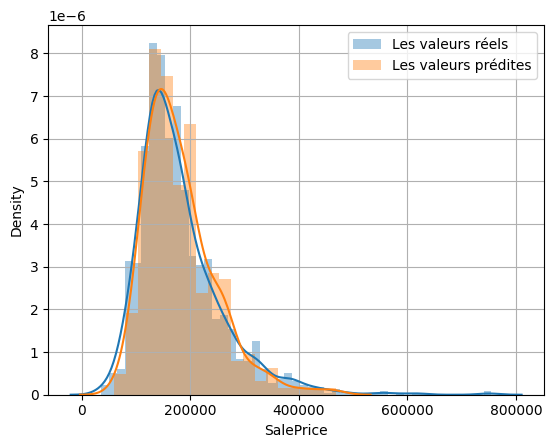

In [ ]:
#tracons le résultat obtenu
plt.grid(True)
sns.distplot(Y, label='Les valeurs réels')
sns.distplot(Y_pred_RFR, label='Les valeurs prédites')
plt.legend()
plt.show()

# RESUMONS NOTRE TRAVAIL AVEC UN TABLEAU RECAPITULATIF

In [ ]:
#récapitulatif des données obtenus
comparaison_score_test_train = pd.DataFrame({
    'Model': ['LinearRegression()', 'DecisionTreeRegressor()', 'RandomForestRegression()'],
    'Score Train': [modelRL.score(X_train, Y_train), modelDTR.score(X_train, Y_train), modelRFR.score(X_train, Y_train)],
    'Score Test': [modelRL.score(X_test, Y_test), modelDTR.score(X_test, Y_test), modelRFR.score(X_test, Y_test)]
})

In [ ]:
print(comparaison_score_test_train)

                      Model  Score Train  Score Test
0        LinearRegression()     0.791152    0.826087
1   DecisionTreeRegressor()     1.000000    0.572469
2  RandomForestRegression()     0.971705    0.860519


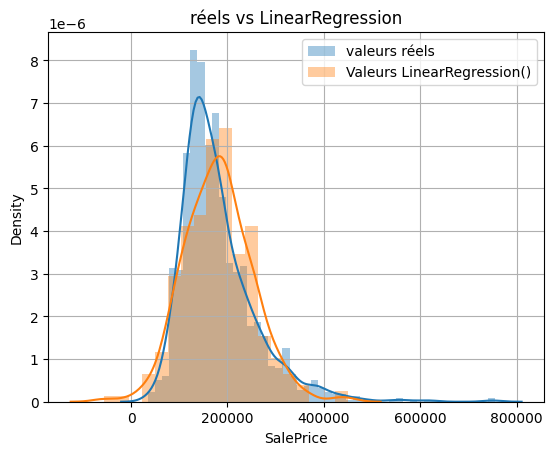

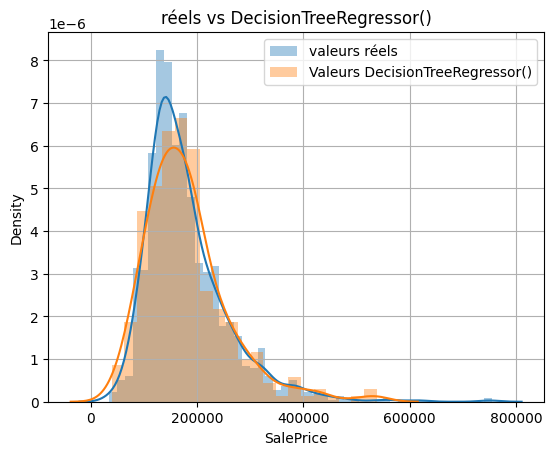

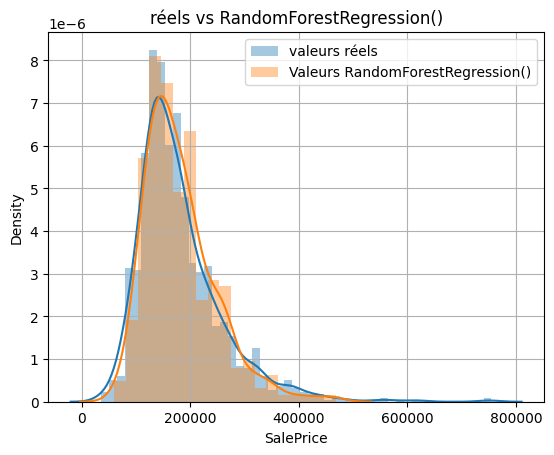

In [ ]:
sns.distplot(Y, label="valeurs réels")
sns.distplot(Y_pred_RL, label="Valeurs LinearRegression()")
plt.title("réels vs LinearRegression")
plt.legend()
plt.grid(True)
plt.show()

sns.distplot(Y, label="valeurs réels")
sns.distplot(Y_pred_DTR, label="Valeurs DecisionTreeRegressor()")
plt.title("réels vs DecisionTreeRegressor()")
plt.legend()
plt.grid(True)
plt.show()

sns.distplot(Y, label="valeurs réels")
sns.distplot(Y_pred_RFR, label="Valeurs RandomForestRegression()")
plt.title("réels vs RandomForestRegression()")
plt.legend()
plt.grid(True)
plt.show()

# **En conclusion la méthode de RandomForestRegression() permet de vraiment bien prédire le prix d'une maison avec de bonne certitude**